In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.optimizers import Adam


def textbox(txt):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    plt.show()
    plt.close()

# 1. Build a deep learning model for the dataset

In [2]:
#Data input
f_location = "https://drive.google.com/file/d/1abp6Oc3XLvN7x2l2r1RHMjWNwoCTanLV/view?usp=sharing"
data_raw = pd.read_csv('https://drive.google.com/uc?export=download&id=' + f_location.split('/')[-2]) #Convert to pandas DataFrames

target_subjects = ['ABE', 'AE', 'BIOE', 'CEE', 'CS', 'CSE', 'ECE', 'ENG', 'IE', 'ME', 'MSE', 'NPRE', 'PHYS', 'SE', 'TAM', 'TE']

grainger_data = data_raw[data_raw['Subject'].isin(target_subjects)].copy()

#Data preprocessing

# Calculate GPA using the provided formula
def calculate_gpa(row):
    grade_points = {
        # 'A+': 4.0, 'A': 4.0, 'A-': 3.7,
        # 'B+': 3.3, 'B': 3.0, 'B-': 2.7,
        # 'C+': 2.3, 'C': 2.0, 'C-': 1.7,
        # 'D+': 1.3, 'D': 1.0, 'D-': 0.7,
        # 'F': 0.0
        'A+': 4.00, 'A': 4.00, 'A-': 3.67,
        'B+': 3.33, 'B': 3.00, 'B-': 2.67,
        'C+': 2.33, 'C': 2.00, 'C-': 1.67,
        'D+': 1.33, 'D': 1.00, 'D-': 0.67,
        'F': 0.00
    }

    total_points = 0
    total_grades = 0

    for grade, points in grade_points.items():
        if grade in row:
            total_points += row[grade] * points
            total_grades += row[grade]
    if total_grades > 0:
        # make the dataset into a binary classification problem:
        # whether the average gpa of all students for this row is at least a B+
        return total_points / total_grades >= 3.33
    else:
        return np.nan

#print(grainger_data)
# Add GPA column to the dataset
grainger_data['GPA'] = grainger_data.apply(calculate_gpa, axis=1)
grainger_data = grainger_data.drop(columns=['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W'])
#print(grainger_data)
# Drop rows with NaN GPA values
grainger_data = grainger_data.dropna(subset=['GPA'])



# Encode categorical features
label_encoders = {}
categorical_features = ['Subject', 'Course Title', 'Sched Type', 'Primary Instructor', 'Term', 'YearTerm']
for feature in categorical_features:
    le = LabelEncoder()
    grainger_data[feature] = le.fit_transform(grainger_data[feature])
    label_encoders[feature] = le

print(le)
# Split data into training/validation and test sets based on year
train_val_data = grainger_data[grainger_data['Year'] < 2023]
test_data = grainger_data[grainger_data['Year'] == 2023]

# Separate features and target variable
X_train_val = train_val_data.drop(columns=['GPA', 'Number', 'Year', 'Term',  'YearTerm'])
feature_names = X_train_val.columns.tolist()
y_train_val = train_val_data['GPA']
X_test = test_data.drop(columns=['GPA', 'Number', 'Year', 'Term',  'YearTerm'])
y_test = test_data['GPA']


print('test')
print(X_train_val)
print(y_train_val)

# Standardize numerical features
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

# Split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Convert everything back to pd dataframe
X_train = pd.DataFrame(X_train, columns=categorical_features[:4])
X_val = pd.DataFrame(X_val, columns=categorical_features[:4])
X_test = pd.DataFrame(X_test, columns=categorical_features[:4])

LabelEncoder()
test
       Subject  Course Title  Sched Type  Primary Instructor
2262         0           491           5                 105
2263         0           228           4                1147
2264         0           766           8                 246
2265         0           128           5                 977
2266         0           342           4                1118
...        ...           ...         ...                 ...
69030       11           975           5                 447
69031       11           973           5                 376
69066       13           550           5                 769
69067       13           554           4                 809
69068       13           551           5                 559

[9914 rows x 4 columns]
2262      True
2263      True
2264      True
2265     False
2266      True
         ...  
69030    False
69031    False
69066    False
69067    False
69068    False
Name: GPA, Length: 9914, dtype: bool


In [3]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense

import tensorflow as tf

# Custom LearningRateSchedule to adjust learning rate based on epoch
class StepLearningRate(LearningRateSchedule):
    def __init__(self, initial_lr, drop_factor, step_size):
        self.initial_lr = initial_lr  # Initial Learning Rate
        self.drop_factor = drop_factor
        self.step_size = step_size  # Adjust the learning rate every `step_size` epochs
        self.epoch = 0

    def __call__(self, step):
        # Calculate the learning rate based on the epoch (decaying every `step_size` epochs)
        current_lr = self.initial_lr * (self.drop_factor ** (self.epoch // self.step_size))
        return tf.cast(current_lr, tf.float32)

    # Update the epoch count at the end of each epoch
    def update_epoch(self, epoch):
        self.epoch = epoch

# Create a StepLearningRate scheduler
initial_lr = 0.01
drop_factor = 0.5
step_size = 10
lr_schedule = StepLearningRate(initial_lr, drop_factor, step_size)

# Custom callback to update the epoch and print the learning rate
class UpdateEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, lr_schedule):
        super(UpdateEpochCallback, self).__init__()
        self.lr_schedule = lr_schedule

    def on_epoch_begin(self, epoch, logs=None):
        # update current epoch
        self.lr_schedule.update_epoch(epoch)
        # print current learning rate
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}")

# Construct Model
model = tf.keras.Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(158, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation="sigmoid")
])

# Compile the model
optimizer = Adam(learning_rate=lr_schedule)  # Use the custom scheduler
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy())

# Initialize the callback
update_epoch_callback = UpdateEpochCallback(lr_schedule)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=[update_epoch_callback]
)

# Test the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: Learning rate is 0.010000
Epoch 1/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7131 - val_loss: 0.6716

Epoch 2: Learning rate is 0.010000
Epoch 2/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6754 - val_loss: 0.6564

Epoch 3: Learning rate is 0.010000
Epoch 3/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6635 - val_loss: 0.6415

Epoch 4: Learning rate is 0.010000
Epoch 4/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6504 - val_loss: 0.6308

Epoch 5: Learning rate is 0.010000
Epoch 5/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6402 - val_loss: 0.6276

Epoch 6: Learning rate is 0.010000
Epoch 6/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6417 - val_loss: 0.6129

Epoch 7: Learning rate is 0.010000
Epoch 7/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6396 - val_loss: 0.6427

Epoch 8: Learning rate is 0.010000
Epoch 8/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6348 - val_loss: 0.6234

Epoch 9: Learni

# 2. Feature Importance

In [4]:
def accuracy(y_pred):
    return np.mean((y_pred > 0.5) == y_test)

y_pred = model.predict(X_test, verbose=0).flatten()
print(f"Accuracy: {accuracy(y_pred) * 100:.2f}%")

Accuracy: 67.72%


In [5]:
def model_0000():
    return model.predict(X_test, verbose=0).mean()

def model_1000(x):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    syntheticdata = pd.concat([tempx, X_test[["Course Title", "Sched Type", "Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0100(y):
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    syntheticdata = pd.concat([X_test[["Subject"]], tempy, X_test[["Sched Type", "Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0010(z):
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    syntheticdata = pd.concat([X_test[["Subject", "Course Title"]], tempz, X_test[["Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0001(w):
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([X_test[["Subject", "Course Title", "Sched Type"]], tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1100(x, y):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    syntheticdata = pd.concat([tempx, tempy, X_test[["Sched Type", "Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1010(x, z):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    syntheticdata = pd.concat([tempx, X_test[["Course Title"]], tempz, X_test[["Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1001(x, w):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([tempx, X_test[["Course Title", "Sched Type"]], tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0110(y, z):
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    syntheticdata = pd.concat([X_test[["Subject"]], tempy, tempz, X_test[["Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0101(y, w):
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([X_test[["Subject"]], tempy, X_test[["Sched Type"]], tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0011(z, w):
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([X_test[["Subject", "Course Title"]], tempz, tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1110(x, y, z):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    syntheticdata = pd.concat([tempx, tempy, tempz, X_test[["Primary Instructor"]]],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1101(x, y, w):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([tempx, tempy, X_test[["Sched Type"]], tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1011(x, z, w):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([tempx, X_test[["Course Title"]], tempz, tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_0111(y, z, w):
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([X_test[["Subject"]], tempy, tempz, tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

def model_1111(x, y, z, w):
    tempx = pd.Series(x, index=X_test.index, dtype=float, name="Subject")
    tempy = pd.Series(y, index=X_test.index, dtype=float, name="Course Title")
    tempz = pd.Series(z, index=X_test.index, dtype=float, name="Sched Type")
    tempw = pd.Series(w, index=X_test.index, dtype=float, name="Primary Instructor")
    syntheticdata = pd.concat([tempx, tempy, tempz, tempw],axis="columns")
    return model.predict(syntheticdata, verbose=0).mean()

In [6]:
def A(m):
    return (y_test == (m.to_numpy() > 0.5)).mean()

Accmodel_0000 = np.abs(model_0000() - y_test).mean()
Accmodel_1000 = A(X_test[["Subject"]].apply(lambda row: model_1000(*row), axis=1))
Accmodel_0100 = A(X_test[["Course Title"]].apply(lambda row: model_0100(*row), axis=1))
Accmodel_0010 = A(X_test[["Sched Type"]].apply(lambda row: model_0010(*row), axis=1))
Accmodel_0001 = A(X_test[["Primary Instructor"]].apply(lambda row: model_0001(*row), axis=1))
Accmodel_1100 = A(X_test[["Subject", "Course Title"]].apply(lambda row: model_1100(*row), axis=1))
Accmodel_1010 = A(X_test[["Subject", "Sched Type"]].apply(lambda row: model_1010(*row), axis=1))
Accmodel_1001 = A(X_test[["Subject", "Primary Instructor"]].apply(lambda row: model_1001(*row), axis=1))
Accmodel_0110 = A(X_test[["Course Title", "Sched Type"]].apply(lambda row: model_0110(*row), axis=1))
Accmodel_0101 = A(X_test[["Course Title", "Primary Instructor"]].apply(lambda row: model_0101(*row), axis=1))
Accmodel_0011 = A(X_test[["Sched Type", "Primary Instructor"]].apply(lambda row: model_0011(*row), axis=1))
Accmodel_1110 = A(X_test[["Subject", "Course Title", "Sched Type"]].apply(lambda row: model_1110(*row), axis=1))
Accmodel_1101 = A(X_test[["Subject", "Course Title", "Primary Instructor"]].apply(lambda row: model_1101(*row), axis=1))
Accmodel_1011 = A(X_test[["Subject", "Sched Type", "Primary Instructor"]].apply(lambda row: model_1011(*row), axis=1))
Accmodel_0111 = A(X_test[["Course Title", "Sched Type", "Primary Instructor"]].apply(lambda row: model_0111(*row), axis=1))
Accmodel_1111 = A(X_test[["Subject", "Course Title", "Sched Type", "Primary Instructor"]].apply(lambda row: model_1111(*row), axis=1))

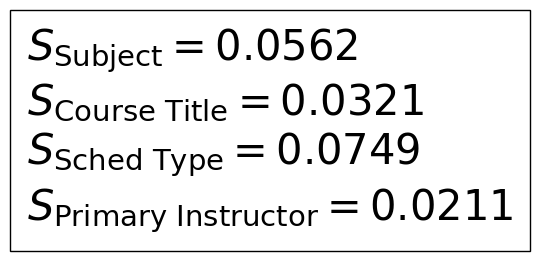

In [7]:
from math import comb

S_subject = 1/4 * (
    (Accmodel_1111 - Accmodel_0111) / comb(3, 3) +
    (Accmodel_1110 - Accmodel_0110) / comb(3, 2) +
    (Accmodel_1101 - Accmodel_0101) / comb(3, 2) +
    (Accmodel_1011 - Accmodel_0011) / comb(3, 2) +
    (Accmodel_1100 - Accmodel_0100) / comb(3, 1) +
    (Accmodel_1010 - Accmodel_0010) / comb(3, 1) +
    (Accmodel_1001 - Accmodel_0001) / comb(3, 1) +
    (Accmodel_1000 - Accmodel_0000) / comb(3, 0)
)

S_course_title = 1/4 * (
    (Accmodel_1111 - Accmodel_1011) / comb(3, 3) +
    (Accmodel_1110 - Accmodel_1010) / comb(3, 2) +
    (Accmodel_1101 - Accmodel_1001) / comb(3, 2) +
    (Accmodel_0111 - Accmodel_0011) / comb(3, 2) +
    (Accmodel_1100 - Accmodel_1000) / comb(3, 1) +
    (Accmodel_0110 - Accmodel_0010) / comb(3, 1) +
    (Accmodel_0101 - Accmodel_0001) / comb(3, 1) +
    (Accmodel_0100 - Accmodel_0000) / comb(3, 0)
)

S_sched_type = 1/4 * (
    (Accmodel_1111 - Accmodel_1101) / comb(3, 3) +
    (Accmodel_1110 - Accmodel_1100) / comb(3, 2) +
    (Accmodel_1011 - Accmodel_1001) / comb(3, 2) +
    (Accmodel_0111 - Accmodel_0101) / comb(3, 2) +
    (Accmodel_1010 - Accmodel_1000) / comb(3, 1) +
    (Accmodel_0110 - Accmodel_0100) / comb(3, 1) +
    (Accmodel_0011 - Accmodel_0001) / comb(3, 1) +
    (Accmodel_0010 - Accmodel_0000) / comb(3, 0)
)

S_primary_instructor = 1/4 * (
    (Accmodel_1111 - Accmodel_1110) / comb(3, 3) +
    (Accmodel_1101 - Accmodel_1100) / comb(3, 2) +
    (Accmodel_1011 - Accmodel_1010) / comb(3, 2) +
    (Accmodel_0111 - Accmodel_0110) / comb(3, 2) +
    (Accmodel_1001 - Accmodel_1000) / comb(3, 1) +
    (Accmodel_0101 - Accmodel_0100) / comb(3, 1) +
    (Accmodel_0011 - Accmodel_0010) / comb(3, 1) +
    (Accmodel_0001 - Accmodel_0000) / comb(3, 0)
)

text=[]
text.append(r"$S_{{\text{{Subject}}}}={:.4f}$".format(S_subject))
text.append(r"$S_{{\text{{Course Title}}}}={:.4f}$".format(S_course_title))
text.append(r"$S_{{\text{{Sched Type}}}}={:.4f}$".format(S_sched_type))
text.append(r"$S_{{\text{{Primary Instructor}}}}={:.4f}$".format(S_primary_instructor))
textbox(text)

We see from the above that schedule type seems to have the highest importance, followed by subject, followed by course title, then primary instructor, though the importance overall is very small, suggesting that there is not much relation between the input features and the output.